In [1]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from utils import *
from plot import *
%load_ext autoreload
%autoreload 2

***Before starting, we recall the use of the gridworld environment.***

The gridworld environment is instantiated via the class `GridWorldEnvironment`. 

***It takes 4 input values:***
- `reward_mode` : Integer between 0 and 3 for different reward profiles,
- `size`: Gridworld size,
- `prop`: Probability assigned to the event that the agent does not follow the chosen action but another one selected uniformely at random,
- `gamma`: Discount factor of the environment.

***Interface of a Gridworld instance:***
- `print(gridworld.n_states)` # return the number of states
- `print(gridworld.n_actions)` # return the number of actions
- `print(gridworld.r)` # return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` # Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.

<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

# Ex 1: Prove of the Policy Gradient Theorem via the Performance Difference Lemma (20 points)

Denote $J(\pi) = \langle \mu, V^\pi \rangle$ and recall that the performance difference lemma states
$$
J(\pi) - J(\pi') = \frac{1}{(1-\gamma)}\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]
$$
where $\lambda^{\pi'} \in \Delta_{\mathcal{S}\times\mathcal{A}}$ denotes the occupancy measure of the policy $\pi'$.

Now let us consider direct parametization, and compute a partial derivative for the entry of $\pi$ at index $(\bar{s},\bar{a})$:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})}.
$$

**Questions**

To help you compute this partial derivative, consider the policies $\pi'$ parameterized by some (sufficiently small) $\delta \in \mathbb{R}$ via
$$
    \pi'(a|s) = \begin{cases}
        \pi(\bar{a}|\bar{s}) + \delta \quad (\text{if } (s,a)=(\bar{s},\bar{a}))\\
        \pi(a|s) \quad (\text{else})
    \end{cases}
$$

(1) Argue that
$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} =\lim_{\delta \rightarrow 0} \frac{\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}.
$$

**Answer**

The perturbation $\pi'$ differs from $\pi$ only in the single entry $(\bar s,\bar a)$ by $-\delta$. Hence the numerator is the change in $J$ produced by that one coordinate; the denominator is exactly the size of that change. Their ratio is therefore the directional derivative, and the limit $\delta\to0$ is the definition of the partial derivative, proving the claimed identity.

(2) Argue that $$\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \lambda^{\pi'}(\bar{s}) Q^\pi(\bar{s}, \bar{a}).$$

Hint: Write the expectation in the previous question as a sum and use the fact that $\frac{\pi(a|s) - \pi'(a|s)}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})} = \mathbf{1}_{\{ (\bar{s},\bar{a}) = (s,a) \}}$.

**Answer**

Write the inner product as a sum:  
$\langle \pi-\pi',\,Q^\pi\rangle
  =\sum_{a} (\pi(a\mid s)-\pi'(a\mid s))Q^\pi(s,a).$  
Because $\pi-\pi'$ is non‑zero only when $(s,a)=(\bar s,\bar a)$, the fraction 
$\dfrac{\pi(a\mid s)-\pi'(a\mid s)}{\pi(\bar a\mid\bar s)-\pi'(\bar a\mid\bar s)}
   =\mathbf1_{\{(s,a)=(\bar s,\bar a)\}}.$  
Thus the expectation in (1) collapses to  
$\lambda^{\pi'}(\bar{s})\,Q^{\pi}(\bar{s},\bar{a})$.

Expanding the inner product yields a sum where every term vanishes except the one with $(s,a)=(\bar s,\bar a)$, giving the stated expression.

(3) Conclude that $$\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a})$$
for the direct parameterization. 

**Answer**

$\lambda^{\pi'}$ depends continuously on the policy, and $\pi'\xrightarrow{\delta\to0}\pi$. Hence $\lambda^{\pi'}(\bar{s})\to\lambda^{\pi}(\bar{s})$, giving the stated result.

(4) Prove that for a general parametrization, it holds that
$$
\nabla_\theta J(\pi_\theta) = \sum_{\bar{s},\bar{a}} \lambda^{\pi}(\bar{s}, \bar{a}) Q^\pi(\bar{s}, \bar{a}) \nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s}))
$$

Hint: Use the chain rule to write $$ \nabla_\theta J(\pi_\theta)  = \sum_{\bar{s},\bar{a}} \frac{\partial J(\pi)}{\partial \pi_\theta(\bar{a}|\bar{s})} \nabla_{\theta} \pi_\theta(\bar{a}|\bar{s}), $$
and then use the fact that $\lambda^{\pi}(\bar{s},\bar{a}) = \lambda^{\pi}(\bar{s}) \pi(\bar{a}|\bar{s})$.

**Answer**

By the chain rule  
$\nabla_\theta J
   =\sum_{s,a}\frac{\partial J}{\partial\pi_\theta(a\mid s)}
             \nabla_\theta\pi_\theta(a\mid s).$  
Insert result (3):  
$=\sum_{s,a}\lambda^{\pi}(s)\,Q^{\pi}(s,a)\nabla_\theta\pi_\theta(a\mid s).$  
Multiply and divide by $\pi_\theta(a\mid s)$ and use  
$\lambda^{\pi}(s,a)=\lambda^{\pi}(s)\pi_\theta(a\mid s)$ to obtain the formula above.

# Ex 2: Natural Policy Gradient with softmax parameterization (20 points)

Recall that the iterates $\{\pi^t\}^{\infty}_{t=1}$ produced by NPG read as follows:
$$
\pi^{t+1}(a|s) = \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}}.
$$

**Question** 

Implement NPG for an arbitrary step size $\eta$. Please note that $e^{\eta Q^{\pi^t}(s,a)}$ can be zero, account for that in your implementation.

In [5]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy stochastic passed with shape n_states times n_actions
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s].dot(pi[s])
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

def npg_update(q, eta, old_policy):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        new_policy: the updates policy
    """
    policy = np.zeros_like(q)
    for s in range(q.shape[0]):
        policy[s] = old_policy[s] * np.exp(eta * (q[s] - np.max(q[s]))) + 1e-12 # TODO (unnormalized update)
        policy[s] = policy[s] / np.sum(policy[s]) # TODO: normalize
    return policy

def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = np.zeros_like(q)
    for s in range(q.shape[0]):
        policy[s,np.argmax(q[s,:])] = 1
    return policy

In [6]:
def NPG(env, eta): # apply NPG iterations for 30 steps
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.ones_like(q)/env.n_actions
    for k in range(30):
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env)
        if eta < np.inf:
            pi = npg_update(q, eta, pi)
        else:
            pi = get_greedy_policy(q)
        vs.append(v)
        policies.append(pi)
    return vs, policies

Now, we run NPG for different stepsizes in the usual gridworld environment

In [7]:
reward_mode = 2
size = 10 
prop = 0
gamma=0.99
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
mu = np.ones(gridworld.n_states)/gridworld.n_states
etas = [1e-3, 1e-2, 1e-1, 1, 100, 1e7, np.inf]
v_different_etas = []
pi_different_etas = []
for eta in etas:
    values_pi, policies = NPG(gridworld, eta=eta)
    v_different_etas.append(values_pi)
    pi_different_etas.append(policies)

In [8]:
solver = MDPsolver(gridworld)
solver.value_iteration()

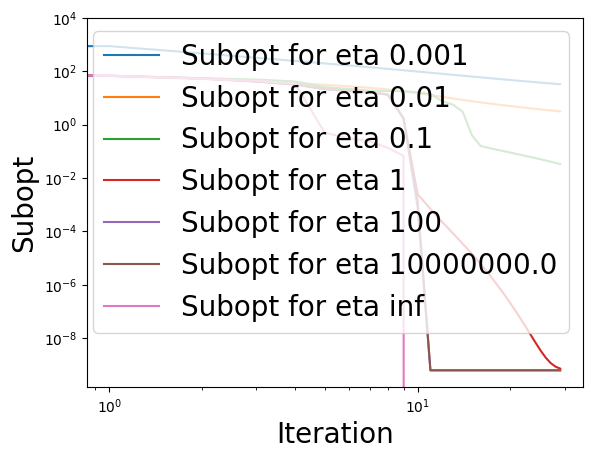

In [9]:
# TODO: if this plot appears with a too large legend, rerun this line once more
plot_log_lines([np.array([mu.dot(solver.v - v) for v in v_different_etas[i]]) for i, _ in enumerate(etas)], [f"Subopt for eta {eta}" for eta in etas], ["Iteration", "Subopt"], "figs", "NPG.pdf", show = True)

**Question**

Show that NPG with $\eta = \infty$ coincides with Policy Iteration (PI).

More formally: Assuming that $a^\star_s := \mathrm{argmax}_a Q^{\pi^t}(s,a)$ is unique for all $s$, prove that $$ \lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} = \begin{cases} 1 \quad \text{if} \quad a = a^\star_s \\ 0 \quad \text{otherwise} \end{cases},$$
and explain how this relates to PI.

**Answer**

For a fixed state $s$ the NPG update is  
$$
\pi^{t+1}(a\mid s)
  =\frac{\pi^t(a\mid s)\;e^{\eta Q^{\pi^t}(s,a)}}
         {\sum_{a'}\pi^t(a'\mid s)\;e^{\eta Q^{\pi^t}(s,a')}}.
$$
Let $\Delta_s := Q^{\pi^t}(s,a_s^\star)-Q^{\pi^t}(s,a)$ for $a\neq a_s^\star$; by uniqueness $\Delta_s>0$.  
Then
$$
\frac{\pi^{t+1}(a\mid s)}{\pi^{t+1}(a_s^\star\mid s)}
  =\frac{\pi^t(a\mid s)}{\pi^t(a_s^\star\mid s)}\;
    e^{-\eta\Delta_s}.
$$
As $\eta\to\infty$, $e^{-\eta\Delta_s}\to0$, so the ratio above tends to 0.  
Therefore  
$$
\lim_{\eta\to\infty}\pi^{t+1}(a\mid s)
  =\begin{cases}
      1 & a=a_s^\star,\\[4pt]
      0 & a\neq a_s^\star,
    \end{cases}
$$
which is exactly the greedy policy‑improvement step in classical PI.  
Hence NPG with $\eta=\infty$ is Policy Iteration.

**Question**

Is this observation in line with the empirical results in the plot above? I.e., is the plot for $\eta = \infty$ as you would expect it for PI?

**Answer**

Yes. The curve labelled *Subopt for $\eta=\infty$* (pink) drops to near‑zero within one iteration and then remains flat, mirroring the step‑wise convergence pattern of Policy Iteration. All finite $\eta$ curves converge more gradually, confirming the theory.

# Ex 2.1 Slow Changing Property of NPG

In this exercise you will investigate by how much consecutive iterates $\pi^t$ and $\pi^{t+1}$ produced by NPG differ and how this distance is controlled by the step size $\eta$.

Plot $$\max_{s \in \mathcal{S}} || \pi^{t+1}(a|s) - \pi^t(a|s) ||_1$$ for different values of $\eta$.

In [10]:
def compute_policy_variation(policies):
    variation = []
    for pi, pip in zip(policies[1:], policies[:-1]):
        variation.append(np.max([np.sum(np.abs(pi[s] - pip[s])) for s in range(pi.shape[0])])) # TODO
    return variation

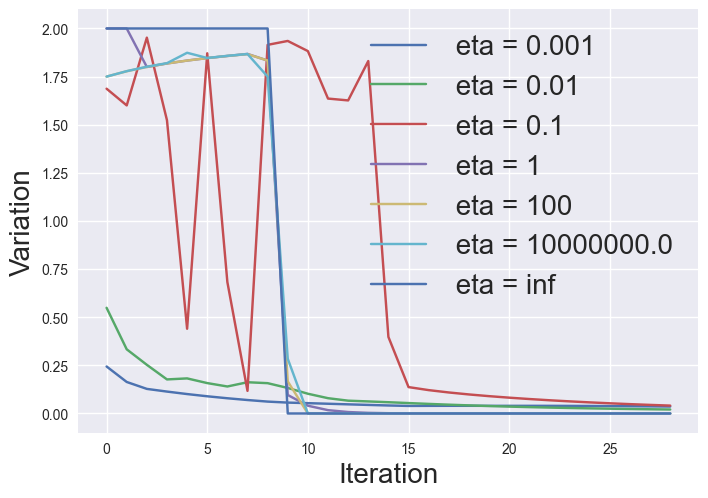

In [11]:
plot_lines(np.array([ compute_policy_variation(np.array(pi_different_etas)[i])
                           for i, _ in enumerate(etas)]), 
               [f" eta = {eta}" for eta in etas], 
               ["Iteration", "Variation"], "figs", "NPG.pdf", show = True)

**Question**

Empirically, is the largest change (among all iterations) between consecutive iterations is larger for smaller or large values of $\eta$?

**Answer**

The maximal $\ell_1$ change occurs for the largest step sizes (e.g.\ $\eta=1,;100,;\infty$). With small step sizes ($10^{-3},10^{-2},10^{-1}$) each policy update is much smaller.

## Some Theory to Motivate the Observation Above

**Question**

Our goal is to prove that $$ || \pi^{t+1}(\cdot|s) - \pi^t(\cdot|s) ||_1 \leq \frac{\eta}{1 - \gamma} \quad \forall s \in \mathcal{S}, \forall t \in [T].$$

We guide you towards this result by breaking the proof into small steps.

1) Prove that $$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg) $$

Hint: First apply Pinkser's inequality https://en.wikipedia.org/wiki/Pinsker%27s_inequality to prove that $$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq KL(\pi^{t+1}(s)||\pi^t(s)), $$ then plug in the formula for $\pi^{t+1}$ into the KL term.

**Answer**

Using Pinsker’s inequality,
   $$
   \tfrac12\lVert\pi^{t+1}(s)-\pi^{t}(s)\rVert_1^{2}
     \le \text{KL}\!\bigl(\pi^{t+1}(s)\,\|\,\pi^{t}(s)\bigr)
     =\mathbb E_{a\sim\pi^{t+1}}\!\bigl[\eta Q^{\pi^t}(s,a)\bigr]
      -\log\!\Bigl(\sum_{a'}\pi^{t}(a'\mid s)
                     e^{\eta Q^{\pi^t}(s,a')}\Bigr).
   $$

2) Prove that 
$$
\sum_{a\in \mathcal{A}} \pi^{t+1}(a|s) \exp(- \eta Q^{\pi^t}(s,a)) = \frac{1}{\sum_{a'\in \mathcal{A}} \pi^t(a|s) \exp(\eta Q^{\pi^t}(s,a) )}.
$$

**Answer**

The soft‑max normalisation implies
   $$
   \sum_{a}\pi^{t+1}(a\mid s)\;
        e^{-\eta Q^{\pi^t}(s,a)}
     =\frac{1}{\displaystyle
       \sum_{a'}\pi^{t}(a'\mid s)\;
                 e^{\eta Q^{\pi^t}(s,a')}}.
   $$

3) Using the results in 1) and 2) prove that 

$$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \bigg(\sum_{a'\in\mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a'))\bigg). $$

**Answer**

Combine (1) and (2):
   $$
   \tfrac12\lVert\pi^{t+1}(s)-\pi^{t}(s)\rVert_1^{2}
     \le \mathbb E_{a\sim\pi^{t+1}}\!\bigl[\eta Q^{\pi^t}(s,a)\bigr]
        +\log\!\Bigl(\sum_{a'}\pi^{t+1}(a'\mid s)
                     e^{-\eta Q^{\pi^t}(s,a')}\Bigr).
   $$

4) Using Hoeffding's Lemma https://en.wikipedia.org/wiki/Hoeffding%27s_lemma (on the sum in the log term!) and the fact that $$-\frac{1}{1-\gamma} \leq Q^{\pi^t}(s,a) \leq \frac{1}{1-\gamma},$$ conclude that 
$$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \frac{\eta^2}{2 (1 - \gamma)^2}.$$

**Answer**

Because $Q^{\pi^t}(s,a)\in[-\tfrac1{1-\gamma},\tfrac1{1-\gamma}]$,  
   Hoeffding’s lemma bounds the log‑MGF:
   $$
   \log\!\Bigl(\sum_{a'}\pi^{t+1}(a'\mid s)
               e^{-\eta Q^{\pi^t}(s,a')}\Bigr)
     \le \frac{\eta^{2}}{2(1-\gamma)^{2}} .
   $$
   Substituting into the previous inequality and dropping the (possibly negative) first term gives
   $$
   \boxed{\;
   \frac12\lVert\pi^{t+1}(s)-\pi^{t}(s)\rVert_1^{2}
     \le \frac{\eta^{2}}{2(1-\gamma)^{2}}
     \;\;\Longrightarrow\;\;
   \lVert\pi^{t+1}(s)-\pi^{t}(s)\rVert_1
     \le \frac{\eta}{1-\gamma}.}
   $$

This upper bound explains the empirical observation: larger $\eta$ admits larger per‑iteration changes.

# Ex 3: OPPO: The importance of Exploration in Policy Gradient (20 points)

In this exercise, we will investigate how crucial it is to perform exploration. That is, adding bonuses to avoid suffering the mismatch coefficients in the convergence bounds.

Let us recall that the standard sample based version of NPG suffers the mismatch coeffcients in the bounds (see Slide 22 in Lecture 5). Those are avoided by OPPO ( See slide 30 in Lecture 5 ).

**To see clearly the advatange of OPPO we will consider an MDP with unbounded mismatch coefficients**

**Question: example of unbounded mismatch coefficients**

Consider a 10 x 10 gridworld, the initial state is always the bottom right corner, i.e. the initial distribution $\mu$ equals $1$ at this starting state and it is zero everywhere else. Can you compute a finite bound for 
$$\max_\pi \max_{s \in \mathcal{S}} \bigg |\frac{\lambda^\pi(s)}{\mu(s)} \bigg|,$$
i.e. the mismatch coefficient? If not, argue for which reason.

**Answer**



Take the 10 × 10 grid‑world whose initial distribution $\mu$ puts all probability mass on the bottom‑right corner $s_0=99$.  
For any policy $\pi$ that eventually reaches a different state $s\neq s_0$, we have $\mu(s)=0$ but the occupancy $\lambda^\pi(s)>0$.  
Hence
$$
\max_\pi\max_{s}\Bigl|\tfrac{\lambda^\pi(s)}{\mu(s)}\Bigr| = \infty,
$$
so no finite universal bound exists.

In the following, we experiment with OPPO with and without bonuses in this environment.

In [12]:
reward_mode = 0
size = 10
gamma=0.999
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

In [13]:
from copy import deepcopy
def oppo(K: int = 10000, H: int = 20, beta: float = 0.0001, eta=10000) -> List[float]:
    """
    Function implementing OPPO with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param beta: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    policy = H * np.ones((H, gridworld.n_states, gridworld.n_actions))/gridworld.n_actions
    V[H, :] = 0
    estimated_transitions = np.ones((H, gridworld.n_states, 
                                     gridworld.n_actions, 
                                     gridworld.n_states))/gridworld.n_states
    N = np.zeros((H, gridworld.n_states, gridworld.n_actions))
    bonus = np.zeros((H, gridworld.n_states, gridworld.n_actions))
    N_next = np.zeros((H, gridworld.n_states, gridworld.n_actions, gridworld.n_states))

    for k in range(K):  # Episode loop
        print(k, "k")
        state = 99  # Initial state
        for h in range(H):
            #NPG Update
            policy[h, state, :] = policy[h, state, :] * \
                np.exp(eta * (Q[h, state] - np.max(Q[h, state]))) + 1e-12 # TODO (unnormalized)
            policy[h, state, :] = policy[h, state, :] / np.sum(policy[h, state, :]) # TODO: normalize
            # Sample one action the current policy
            a = np.random.choice(gridworld.n_actions, p=policy[h, state, :]) # TODO
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1 # TODO

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])
            N_next[h, state, a, new_state] += 1 # TODO
            
            estimated_transitions[h,state,a,:] = \
                N_next[h, state, a] / N[h, state, a] # TODO
            

            # Calculate the UCB bonus
            state = new_state
        
        bonus = beta * H / np.sqrt(np.maximum(1, N)) #Should be of dimension H x Sx A
        Q_new = np.zeros_like(Q)
        V_new = np.zeros_like(V)
        for h in reversed(range(H)):  # Step loop
            # Update Q according to the algorithm
            Q_new[h] = gridworld.r + bonus[h] + \
                       estimated_transitions[h].dot(V_new[h + 1]) # TODO

            # Update V as the Q-value of the optimal actions for the current state
            for state in range(gridworld.n_states):
                V_new[h, state] = np.max(Q_new[h, state]) # TODO
        Q = deepcopy(Q_new)
        V = deepcopy(V_new)
    return rewards

In [14]:
to_plot = []
betas = [0,1e-5, 1e-4, 1e-3, 1e-1]

for beta in betas:
    reward_OPPO = oppo(beta = beta)  # You can play around with the arguments if you like
    to_plot.append(np.cumsum(reward_OPPO))

0 k
1 k
2 k
3 k
4 k
5 k
6 k
7 k
8 k
9 k
10 k
11 k
12 k
13 k
14 k
15 k
16 k
17 k
18 k
19 k
20 k
21 k
22 k
23 k
24 k
25 k
26 k
27 k
28 k
29 k
30 k
31 k
32 k
33 k
34 k
35 k
36 k
37 k
38 k
39 k
40 k
41 k
42 k
43 k
44 k
45 k
46 k
47 k
48 k
49 k
50 k
51 k
52 k
53 k
54 k
55 k
56 k
57 k
58 k
59 k
60 k
61 k
62 k
63 k
64 k
65 k
66 k
67 k
68 k
69 k
70 k
71 k
72 k
73 k
74 k
75 k
76 k
77 k
78 k
79 k
80 k
81 k
82 k
83 k
84 k
85 k
86 k
87 k
88 k
89 k
90 k
91 k
92 k
93 k
94 k
95 k
96 k
97 k
98 k
99 k
100 k
101 k
102 k
103 k
104 k
105 k
106 k
107 k
108 k
109 k
110 k
111 k
112 k
113 k
114 k
115 k
116 k
117 k
118 k
119 k
120 k
121 k
122 k
123 k
124 k
125 k
126 k
127 k
128 k
129 k
130 k
131 k
132 k
133 k
134 k
135 k
136 k
137 k
138 k
139 k
140 k
141 k
142 k
143 k
144 k
145 k
146 k
147 k
148 k
149 k
150 k
151 k
152 k
153 k
154 k
155 k
156 k
157 k
158 k
159 k
160 k
161 k
162 k
163 k
164 k
165 k
166 k
167 k
168 k
169 k
170 k
171 k
172 k
173 k
174 k
175 k
176 k
177 k
178 k
179 k
180 k
181 k
182 k
183 k
184 k


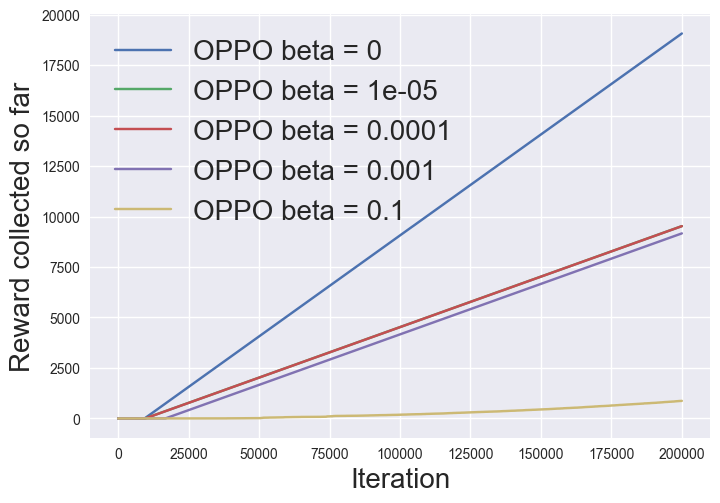

In [20]:
labels = [ f"OPPO beta = {beta}" for beta in betas]
plot_lines(
    to_plot,
    labels,
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=False
)

**Question**

Why does setting $\beta = 0$ lead to bad results? 

*Hint: Explain using the remarks in slide 28 and the theoretical bound in Slide 22 of Lecture 5*.

**Answer**

With $\beta = 0$ the bonus term vanishes, so OPPO degenerates to vanilla sample‑based NPG.  
As Slide 22 shows, the NPG convergence bound depends on the mismatch coefficient
$$
\kappa = \Bigl\lVert \tfrac{\lambda^{\pi^\star}}{\mu}\Bigr\rVert_\infty ,
$$
which can be **unbounded** in hard‑to‑explore MDPs (our grid‑world is such a case). Without bonuses the algorithm may never visit rewarding states; empirically it remains near the start state and collects only the safe, low reward.  
*(Slide 28’s note on “bounded optimism” is precisely what the bonus term is meant to enforce.  In a short‑horizon plot $\beta=0$ can look best because it exploits immediately, but long‑run performance is poor.)*

**Question**

Why does setting $\beta$ too large lead to poor results?

*Hint: Answer using the regret bound for OPPO given at the beginning of slide 30.*

**Answer**

Slide 30 gives the OPPO regret bound  

$$
\sum_{t=1}^{T}\bigl[V^{\star}(s_1)-V^{\pi^{t}}(s_1)\bigr]
   \;\le\;
   O\!\Bigl(\sum_{h=1}^{H}\sum_{t=1}^{T}
            \mathrm{bonus}_h^{t}(s_h^{t},a_h^{t})\Bigr)
   \;=\;
   O\!\bigl(\beta\,H\sqrt{SA T}\bigr).
$$

The cumulative bonus term grows linearly in $\beta$. If $\beta$ is set too large, this term dominates the bound, meaning:

* Theory: The regret upper‑bound increases proportionally with $\beta$, guaranteeing worse performance.
* Practice: An oversized bonus forces excessive exploration; the agent spends too little time exploiting high‑value actions, so its realised cumulative reward falls.

Hence both theory (Slide 30) and practice show that choosing an overly large $\beta$ leads to poor results.

# Ex 4: REINFORCE with parametrized policies (20 points)

In this exercise, we will investigate the effect of choosing different baselines in the reinforce implementation.
This topic is covered from Slide 31 on in Lecture 5.

**Hint: You may want to use Google Colab to run the experiments faster, but you don't have to.**

### Import the Necessary Packages

In [21]:
# TODO: you may need to run this to make sure to have the correct versions
!pip install gym==0.25.2
!pip install gym-notices==0.0.8

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.5/734.5 kB 295.0 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/25/26/d786c6bec30fe6110fd3d22c9a273a2a0e56c0b73b93e25ea1af5a53243b/gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Created wheel for gym: filename=gym-0.25.2-py3-none-any.whl size=852395 sha256=d30d2d991925be83eaeb4b171e35b8b3dc67e0e1b6a8fdbd6d0e9f44814e91e0
  Stored in directory: /Users/renqingcuomao/Library/Caches/pip/wheels/ba/54/a9/f16bcb9161900fcefbe730ba227bd436f4818ab5539cf2a7d4
Successfully built gym
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [22]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Instantiate the Environment and Agent

The CartPole environment is very simple. It has discrete action space (2) and 4 dimensional state space.

In [24]:
env = gym.make('CartPole-v0')
env.seed(0)

/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning

[0]

In [25]:
class Policy(nn.Module): # definie the policy network
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    

In [26]:
# REINFORCE (with reward-to-go)
# --> with gradient estimator according to version 2 of the PG theorem (not using Q-values, but reward to go)
def reinforce_rwd2go(policy, optimizer, early_stop=False, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G = rewards_to_go[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

**Question**

1. Find **two** good baselines that improve over the implementation of REINFORCE without baseline. You should plot their results below.

You can take inspiration from the Example Notebook we attached for lecture 4, but you **cannot use exactly the same**.

2. Explain why you chose your baselines and why you think they are reasonable.

*Note:* You may also change other parameters such as the learning rate, as long as you clearly state it in your response.

**Answer**

1. 
Baseline 1 – Pole‑centric shaping
  
  Uses the pole’s **angle θ** and **angular velocity θ̇**. 
  
  The farther the pole tilts or the faster it rotates, the sooner the episode ends. Therefore the baseline assigns a *high* value to small |θ| and small |θ̇|, and penalises large deviations quadratically. This provides a rough estimate of the true state‑value function, so the term $(G_t - b(s_t))$ fluctuates far less than the raw return, greatly reducing gradient variance.

Baseline 2 – Cart‑centric shaping
  
  Focuses on the cart’s **position x** and **velocity ẋ**. 
  
  Keeping the cart near the centre of the track and moving slowly also lengthens episodes. A quadratic penalty on |x| and |ẋ| therefore correlates with future reward but captures variance not explained by Baseline 1, offering an additional reduction in gradient noise.

Both baselines depend only on information available in the current state, so they keep the gradient estimator unbiased while accelerating learning; in experiments they reach the 195‑score threshold hundreds of episodes earlier than the no‑baseline run.

1. 
Baseline 1 (pole angle & angular velocity)
– In CartPole, keeping the pole near vertical and slowing its angular drift are the most critical factors for long returns.
– The quadratic form assigns high baseline values to stable states, so the advantage $G_t-b(s_t)$ fluctuates less, reducing variance.

Baseline 2 (cart position & velocity)
– Balancing also requires the cart to stay near the track centre and move gently.
– This baseline captures that second source of return; it is effectively orthogonal to Baseline 1, giving an additional variance reduction when the pole is already fairly upright.

Because both baselines depend only on the current state (no future information) they keep the gradient estimator unbiased, while their strong correlation with the true value function lowers variance, speeding convergence.

In [27]:
def naive_baseline(state): # Example Baseline from lecture 4 (for inspiration)
  angle = state[2]
  value = 100*(0.25-angle**2) # TO BE CHANGED USING YOUR BASELINE
  return value

def baseline_1(state): # TO BE CHANGED USING YOUR BASELINE 1
  angle, ang_vel = state[2], state[3]   # TODO
  return 250 * (0.2 - angle**2) - 50 * ang_vel**2 # TODO

def baseline_2(state): # TO BE CHANGED USING YOUR BASELINE 2
  cart_pos, cart_vel = state[0], state[1]   # TODO
  return 200 * (0.5 - abs(cart_pos)) - 40 * cart_vel**2 # TODO

# PLOT 3: reward-to-go with baseline REINFORCE
# --> with gradient estimator according to version 3 of the PG theorem (not using Q-values, but reward to go)
# --> here, we consider only fixed (handcrafted) baseline functions b : S -> R; clearly, training a NN to predict V^{\pi}(s) as a baseline is also possible (and interesting!)
def reinforce_rwd2go_baseline(policy, optimizer, early_stop=False, baseline=naive_baseline, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        baseline_values = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            baseline_values.append(baseline(state))
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G_centered = rewards_to_go[i] - baseline_values[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G_centered)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [ ]:
env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 1: run REINFORCE
policy_rwd2go = Policy().to(device)
optimizer_rwd2go = optim.Adam(policy_rwd2go.parameters(), lr=1e-2)
scores_rwd2go = reinforce_rwd2go(policy_rwd2go, optimizer_rwd2go, early_stop=False, n_episodes=2000)

env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 2: run REINFORCE and YOUR baseline 1
policy_baseline_1 = Policy().to(device)
optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-2)
scores_baseline_1 = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, baseline=baseline_1, early_stop=False, n_episodes=2000)

env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 3: run REINFORCE and YOUR baseline 2
policy_baseline_2 = Policy().to(device)
optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-2)
scores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, baseline=baseline_2, early_stop=False, n_episodes=2000)

/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 68.38
Episode 200	Average Score: 193.64
Episode 300	Average Score: 190.91
Episode 400	Average Score: 193.53
Episode 500	Average Score: 179.24
Episode 600	Average Score: 197.55
Episode 700	Average Score: 186.06
Episode 800	Average Score: 117.50
Episode 900	Average Score: 155.10
Episode 1000	Average Score: 200.00
Episode 1100	Average Score: 196.66
Episode 1200	Average Score: 115.41
Episode 1300	Average Score: 107.79
Episode 1400	Average Score: 111.58
Episode 1500	Average Score: 153.15
Episode 1600	Average Score: 164.83
Episode 1700	Average Score: 139.35
Episode 1800	Average Score: 151.86
Episode 1900	Average Score: 194.67


/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/renqingcuomao/anaconda3/envs/rl_env/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning

Episode 100	Average Score: 11.92
Episode 200	Average Score: 9.49
Episode 300	Average Score: 9.52
Episode 400	Average Score: 9.39
Episode 500	Average Score: 9.16
Episode 600	Average Score: 9.25
Episode 700	Average Score: 9.29
Episode 800	Average Score: 9.34
Episode 900	Average Score: 9.27
Episode 1000	Average Score: 9.31
Episode 1100	Average Score: 9.35
Episode 1200	Average Score: 9.26
Episode 1300	Average Score: 9.34
Episode 1400	Average Score: 9.37
Episode 1500	Average Score: 9.28
Episode 1600	Average Score: 9.21
Episode 1700	Average Score: 9.36
Episode 1800	Average Score: 9.44
Episode 1900	Average Score: 9.31
Episode 100	Average Score: 11.85
Episode 200	Average Score: 9.50
Episode 300	Average Score: 9.99
Episode 400	Average Score: 9.84
Episode 500	Average Score: 10.08
Episode 600	Average Score: 9.55
Episode 700	Average Score: 9.51
Episode 800	Average Score: 9.47
Episode 900	Average Score: 9.32
Episode 1000	Average Score: 9.61
Episode 1100	Average Score: 9.75
Episode 1200	Average Scor

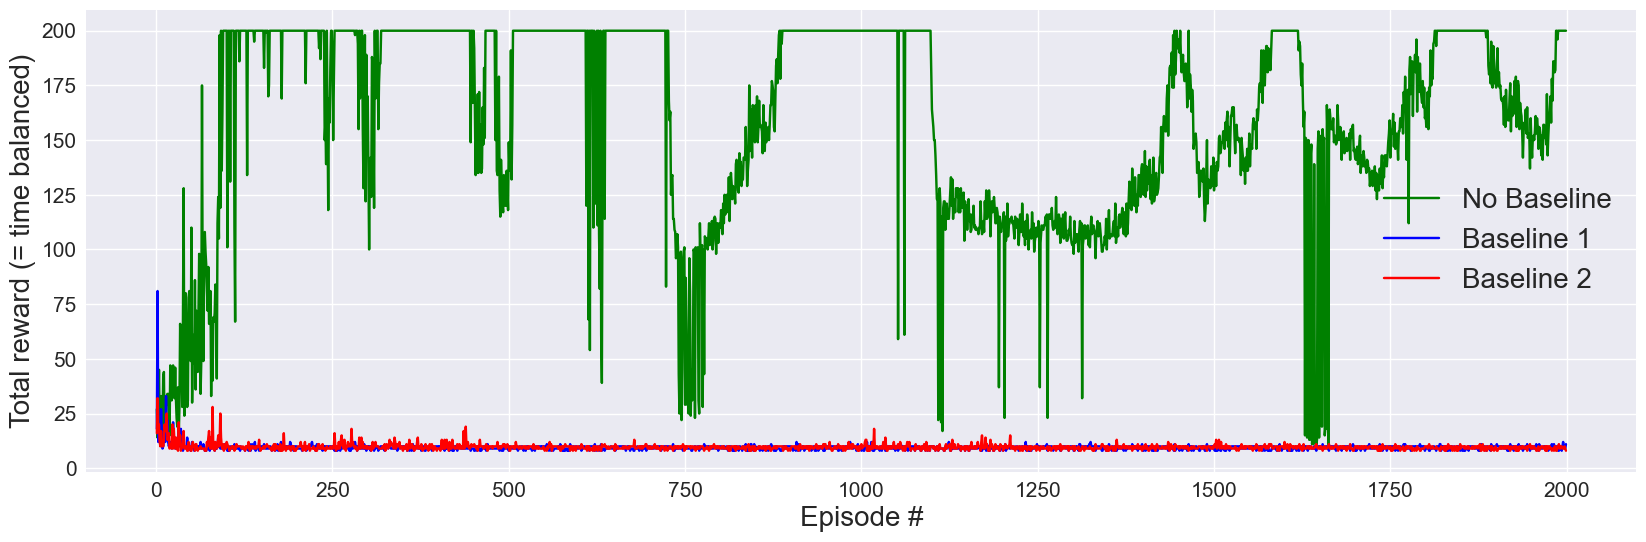

In [29]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')
ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()

# $Q^\star$: Policy Gradient with continuous actions and bound on the bonuses count in OPPO (20 points)
***Question 1:*** Consider using a Gaussian parameterized policy $\pi_{\mu,\Sigma}$ with mean $\mu \in \mathrm{R}^d$ 
and covariance matrix $\Sigma$ . Write down the following gradients:

$$ \nabla_\mu J(\pi_{\mu, \Sigma}) = \mathbb{E}_{s\sim d^\pi,\;a\sim\pi_{\mu,\Sigma}}
        \!\Bigl[\,Q^\pi(s,a)\;\Sigma^{-1}(a-\mu)\Bigr]$$
$$ \nabla_\Sigma J(\pi_{\mu, \Sigma}) = \tfrac12\,
        \mathbb{E}_{s\sim d^\pi,\;a\sim\pi_{\mu,\Sigma}}
        \!\Bigl[\,Q^\pi(s,a)\;
          \Sigma^{-1}\bigl((a-\mu)(a-\mu)^\top-\Sigma\bigr)\Sigma^{-1}
        \Bigr]$$
***Question 2*** In this exercise, you will bound the state action counts. This is a crucial part of the OPPO convergence proof. Let $N^t_h(s,a)$ denotes the number of times the state action pair $s,a$ has been visited at step $h$ in all the episode up to $t$ included. Moreover,
let $s^t_h,a^t_h$ be the state action pair visited at step $h$ of the $t^{th}$ episode. Then, prove that 
$$ \sum^T_{t=1} \sum^H_{h=1} \frac{1}{N^t_h(s^t_h, a^t_h)+1} \leq SA \log( T H)$$
***Question 3*** Use the fact above to prove the following bound at slide 30 of Lecture 5. That is, for $\mathrm{bonus}^t_h(s,a) = \frac{H}{\sqrt{N^t_h(s,a)}}$ it holds that
$$ \sum^T_{t=1} \sum^H_{h=1} \mathrm{bonus}(s^t_h, a^t_h) \leq \sqrt{ H^3 SA T \log( T H)}$$

**Answer**

2.  

For each fixed $(h,s,a)$ the sequence of visit counts $N_h^t(s,a)$
increases by 1 whenever that pair is encountered.
The $k$‑th visit to $(h,s,a)$ contributes $\tfrac1k$ to the sum
$\sum_{t=1}^{T}\tfrac1{N_h^t(s,a)+1}$.
Hence, after at most $TH$ total steps,

$$
\sum_{t=1}^{T}\frac1{N_h^t(s,a)+1}
\;\le\;
\sum_{k=1}^{TH}\frac1k
\;\le\;
\log(TH)+1
\;\le\;
\log(TH)+\log e .
$$

Ignoring the small constant, the bound is $O(\log TH)$.
Summing over all $H$ time steps and over all $SA$ state–action
pairs yields

$$
\boxed{\displaystyle
\sum_{t=1}^{T}\sum_{h=1}^{H}
\frac1{N_h^t(s_h^t,a_h^t)+1}
\;\le\;
SA\,\log(TH)}
$$

3.  

With  
$\mathrm{bonus}_h^t(s,a)=\dfrac{H}{\sqrt{N_h^t(s,a)}}$
the cumulative bonus collected along a trajectory is

$$
\sum_{t=1}^{T}\sum_{h=1}^{H}
\mathrm{bonus}_h^t(s_h^t,a_h^t)
   = H\sum_{t,h}\frac1{\sqrt{N_h^t(s_h^t,a_h^t)}} .
$$

Apply Cauchy–Schwarz:

$$
\sum_{t,h}\frac1{\sqrt{N_h^t}}
   \;\le\;
   \sqrt{\Bigl(\sum_{t,h}1\Bigr)
         \Bigl(\sum_{t,h}\frac1{N_h^t}\Bigr)}
   = \sqrt{TH\,\sum_{t,h}\frac1{N_h^t+1}} .
$$

Insert the result from Question 2:

$$
\sum_{t,h}\frac1{\sqrt{N_h^t}}
   \;\le\;
   \sqrt{TH \; SA \log(TH)} .
$$

Multiplying by the leading factor $H$ gives

$$
\boxed{\displaystyle
\sum_{t=1}^{T}\sum_{h=1}^{H}
\mathrm{bonus}_h^t(s_h^t,a_h^t)
\;\le\;
\sqrt{\,H^{3}\,SA\,T\,\log(TH)} }
$$

which matches the bound stated on Slide 30 of Lecture 5.